#<font face="Cambria" color="#36648B">**Análisis de Patrones Espaciales: Interrelación entre la Densidad de Cultivos de Coca y la Tasa Anual de Deforestación en Putumayo, Colombia (2014)**.</font>
<font face="Cambria" color="black">Diana Millan</font>


Este notebook permitió analizar los datos de Putumayo mediante técnicas geoespaciales, dando como producto principal el siguiente mapa.
Los principales resultados acá expuestos se complementaron y se verificaron mediante resultados satelitales como se evidencia en el siguiente repositorio de Google Earth Engine 
https://ee-millanorduzdiana.projects.earthengine.app/view/putumayoanalysis

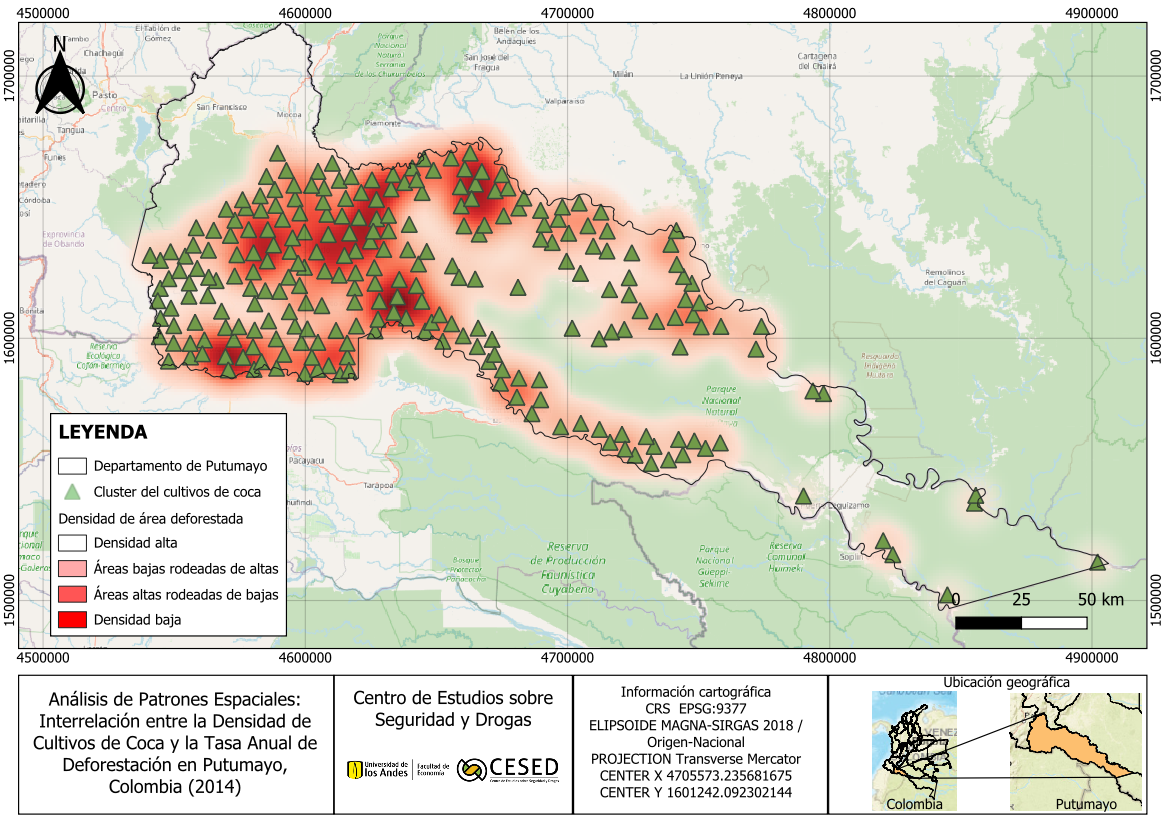

##Instalación de librerias necesarias

In [ ]:
!pip install esda
!pip install libpysal
!pip install pysal


In [ ]:
!pip install geopandas matplotlib seaborn


In [ ]:
!pip install folium


In [ ]:
!pip install Basemap

In [ ]:
pip install cartopy

In [ ]:
# plot GIS data on different basemaps by geopandas and contextily
!pip install geopandas
!pip install contextily

In [ ]:
from google.colab import drive # Se importan los archivo del Drive actual
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import geopandas as gpd
from pysal.explore import esda
from pysal.lib import weights
import ee
import geemap
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import contextily
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline
import numpy as np
from mpl_toolkits.basemap import Basemap
import pandas as pd
import contextily as ctx # for basemaps

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [ ]:
data_putumayo = gpd.read_file("/content/drive/MyDrive/2.TRABAJOS/CESED/sf_limpio_diana.geojson")

##Análisis exploratorio de datos (AED)

In [ ]:
data_putumayo.describe()

grilla  areacoca_2014  loss_mts_2014  loss_ha_2014  \
count   25971.000000    6168.000000   25971.000000  25971.000000   
mean   179737.325863       2.203051     247.159022      0.024716   
std     37731.039354       2.912288     935.153134      0.093515   
min    105812.000000       0.000800       0.000000      0.000000   
25%    151773.500000       0.557275       0.000000      0.000000   
50%    178069.000000       1.331900       0.000000      0.000000   
75%    204667.500000       2.733950      90.000000      0.009000   
max    283019.000000      52.761300   24328.575154      2.432858   

        p_loss_2014  tree_cover_ha_2014  tree_cover_mts_2014  
count  25971.000000        25971.000000         25971.000000  
mean       0.736214            3.282087         32820.866702  
std        2.612728            0.787060          7870.596178  
min        0.000000            0.000000             0.000000  
25%        0.000000            2.911775         29117.749367  
50%        0.000000            3.624034         36240.342119  
75%        0.275427            3.885852         38858.515044  
max       65.212542            3.899412         38994.124192

In [ ]:
# Información general sobre el conjunto de datos
print("Información general sobre el conjunto de datos:")
print(data_putumayo.info())

Información general sobre el conjunto de datos:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 25971 entries, 0 to 25970
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   grilla               25971 non-null  int64   
 1   areacoca_2014        6168 non-null   float64 
 2   loss_mts_2014        25971 non-null  float64 
 3   loss_ha_2014         25971 non-null  float64 
 4   p_loss_2014          25971 non-null  float64 
 5   tree_cover_ha_2014   25971 non-null  float64 
 6   tree_cover_mts_2014  25971 non-null  float64 
 7   geometry             25971 non-null  geometry
dtypes: float64(6), geometry(1), int64(1)
memory usage: 1.6 MB
None


In [ ]:
# Seleccionar columnas para el análisis
selected_columns = ['areacoca_2014', 'loss_mts_2014', 'loss_ha_2014', 'p_loss_2014', 'tree_cover_ha_2014', 'tree_cover_mts_2014']


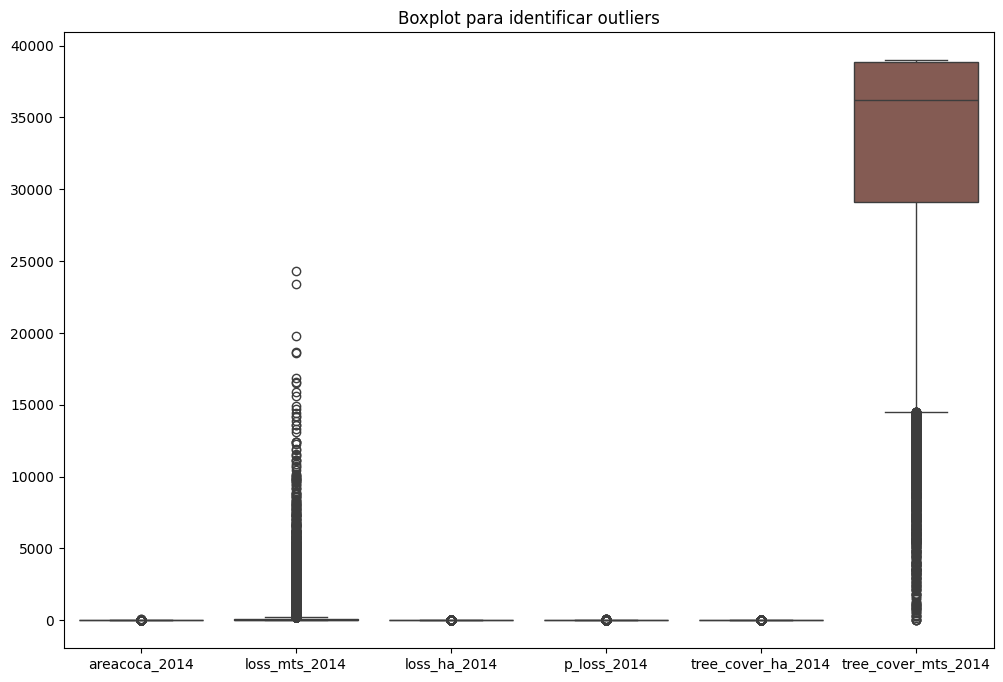

In [ ]:
# Boxplot para identificar outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=data_putumayo[selected_columns])
plt.title('Boxplot para identificar outliers')
plt.show()

<Figure size 1200x800 with 0 Axes>

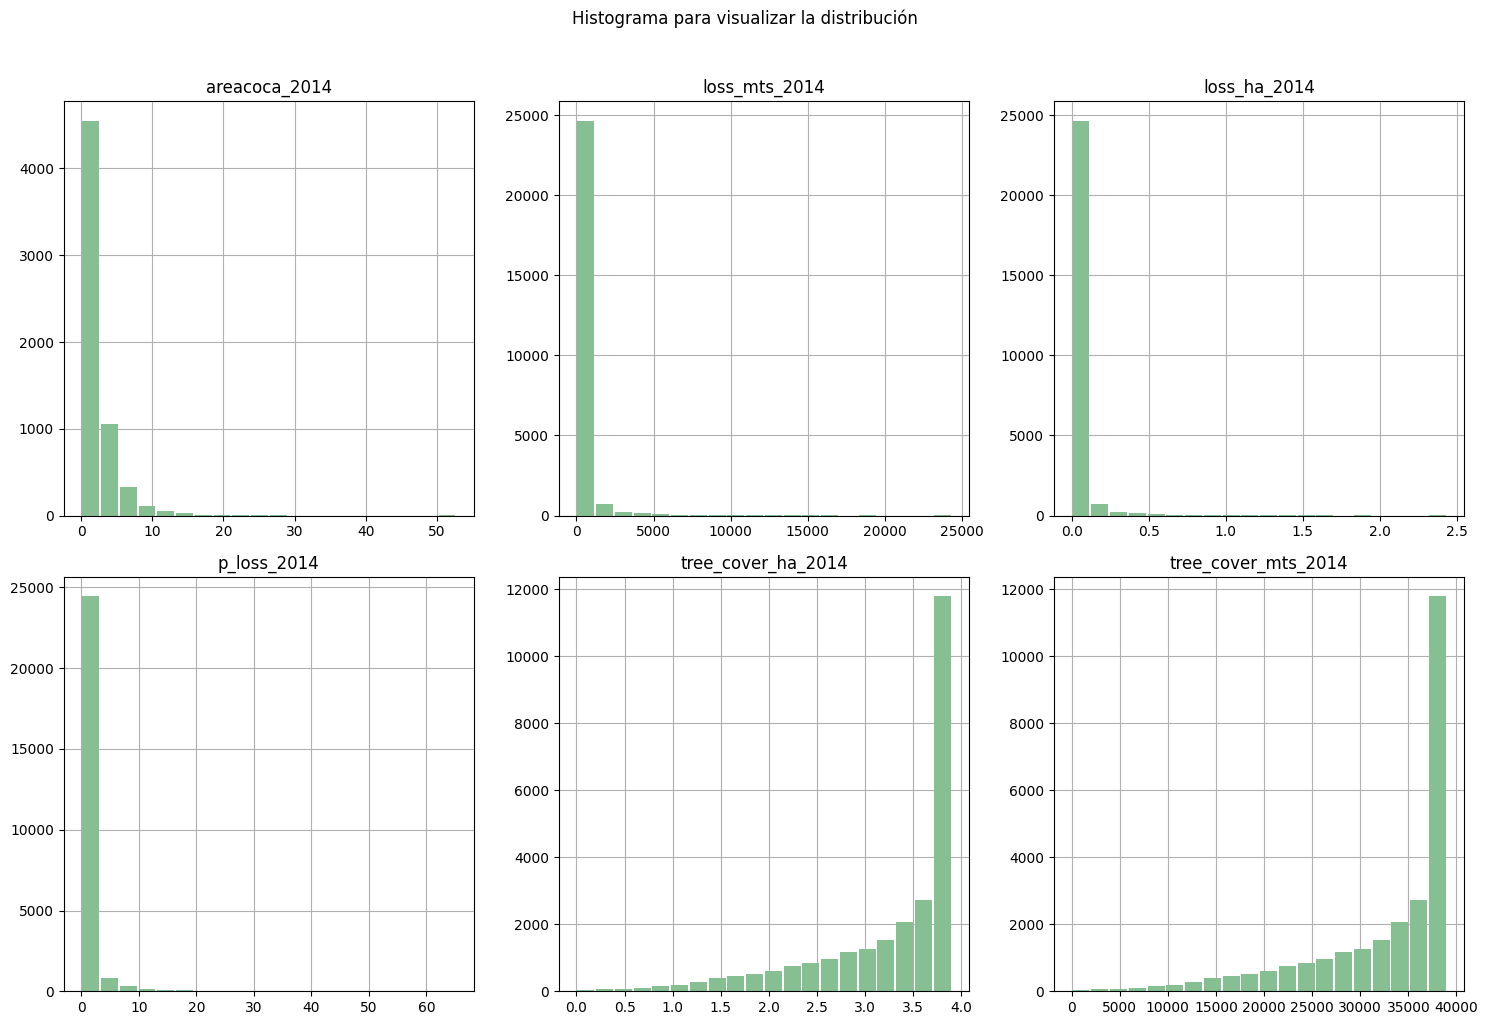

In [ ]:
# Histograma para visualizar la distribución
plt.figure(figsize=(12, 8))
data_putumayo[selected_columns].hist(bins=20, figsize=(15, 10), layout=(2, 3), color='#86bf91', zorder=2, rwidth=0.9)
plt.suptitle('Histograma para visualizar la distribución', y=1.02)
plt.tight_layout()
plt.show()

Los histogramas de "Areacoca 2014" y "Loss mts 2014" revelan una distribución similar, indicando una relación positiva entre la densidad de coca y la pérdida de cobertura arbórea en Putumayo en 2014. La imagen proporciona evidencia de esta asociación fuerte, sugiriendo que las áreas con mayor densidad de coca experimentaron una mayor pérdida de cobertura arbórea. A pesar de ello, la mayoría de la pérdida de cobertura arbórea fue relativamente pequeña en términos de porcentaje, y Putumayo aún mantenía una cobertura arbórea significativa en 2014.

En el dataset se evidencia que hay una distribución de datos con valores de cero, y valores nulos especialmente en el "área coca" que corresponden a áreas con ausencia de cultivos de coca en su mayoria debido a que son áreas protegidas o con otros usos del suelo. Por lo tanto, para el análisis se crea otro dataframe para analizar de manera simultanea la distribución y correlación de estas variables.

In [ ]:
# Crear un nuevo GeoDataFrame sin valores nulos en las columnas seleccionadas
data_no_nulls = data_putumayo.dropna(subset=selected_columns)
# Información general sobre el nuevo conjunto de datos sin valores nulos
print("Información general sobre el nuevo conjunto de datos sin valores nulos:")
print(data_no_nulls[selected_columns].info())

Información general sobre el nuevo conjunto de datos sin valores nulos:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6168 entries, 30 to 24057
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   areacoca_2014        6168 non-null   float64
 1   loss_mts_2014        6168 non-null   float64
 2   loss_ha_2014         6168 non-null   float64
 3   p_loss_2014          6168 non-null   float64
 4   tree_cover_ha_2014   6168 non-null   float64
 5   tree_cover_mts_2014  6168 non-null   float64
dtypes: float64(6)
memory usage: 337.3 KB
None


In [ ]:
# Ruta para guardar el nuevo GeoJSON en Google Drive
output_geojson_path = '/content/drive/MyDrive/2.TRABAJOS/CESED/dataputumayo_no_nulls.geojson'

# Guardar el GeoDataFrame en formato GeoJSON
data_no_nulls.to_file(output_geojson_path, driver='GeoJSON')

print(f"El GeoDataFrame sin valores nulos se ha guardado en '{output_geojson_path}'.")

El GeoDataFrame sin valores nulos se ha guardado en '/content/drive/MyDrive/2.TRABAJOS/CESED/dataputumayo_no_nulls.geojson'.


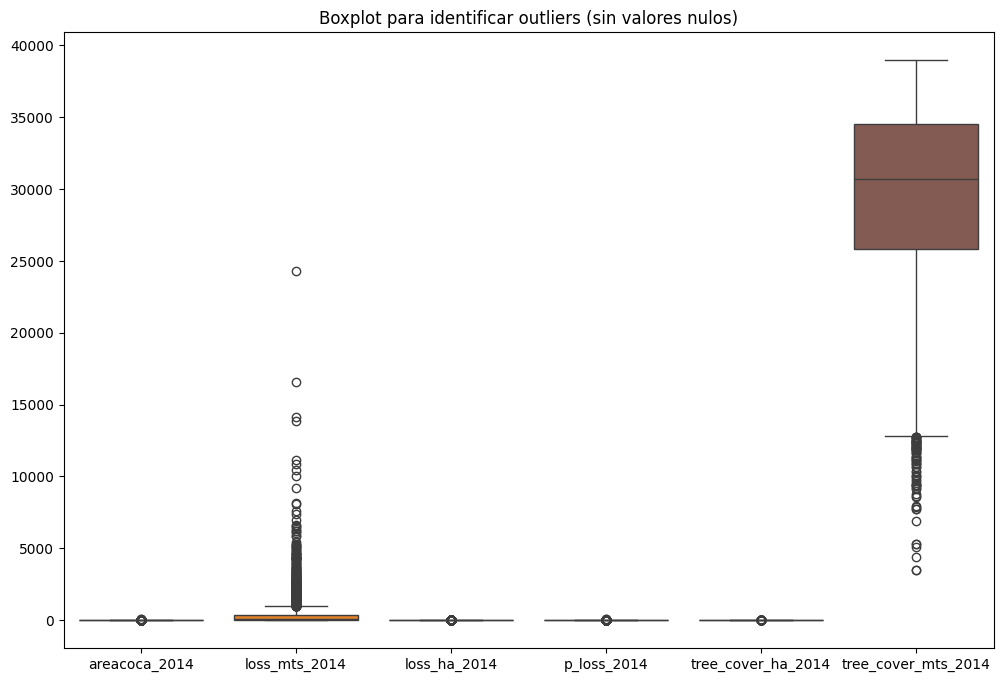

<Figure size 1200x800 with 0 Axes>

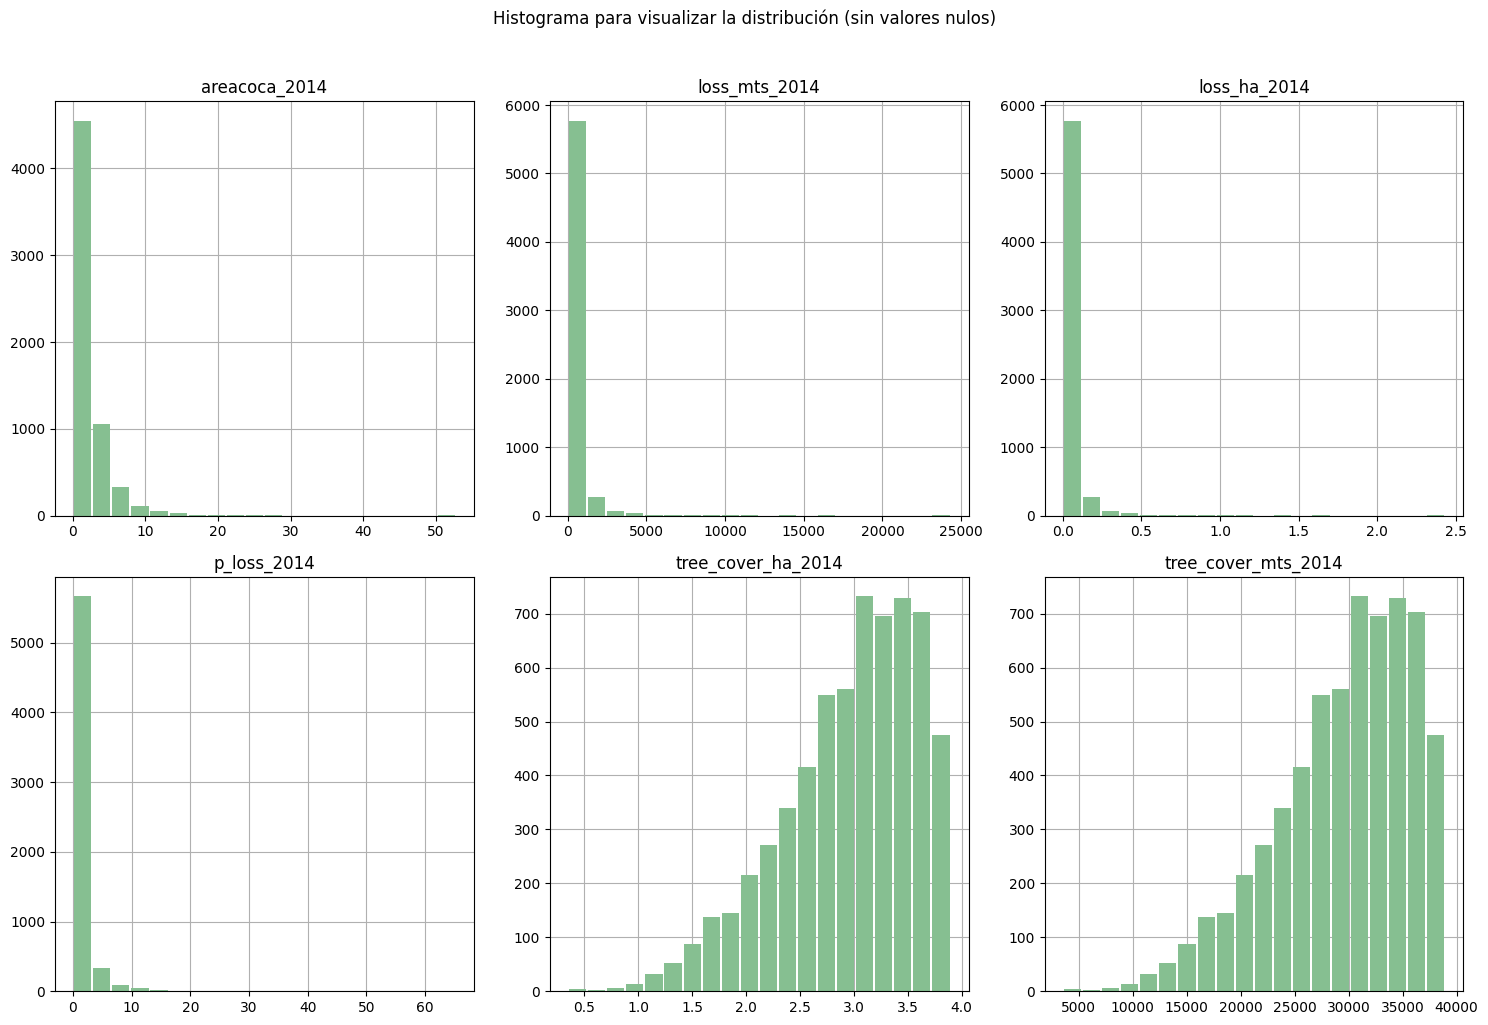

In [ ]:
# Boxplot para identificar outliers en el nuevo conjunto de datos sin valores nulos
plt.figure(figsize=(12, 8))
sns.boxplot(data=data_no_nulls[selected_columns])
plt.title('Boxplot para identificar outliers (sin valores nulos)')
plt.show()

# Histograma para visualizar la distribución en el nuevo conjunto de datos sin valores nulos
plt.figure(figsize=(12, 8))
data_no_nulls[selected_columns].hist(bins=20, figsize=(15, 10), layout=(2, 3), color='#86bf91', zorder=2, rwidth=0.9)
plt.suptitle('Histograma para visualizar la distribución (sin valores nulos)', y=1.02)
plt.tight_layout()
plt.show()

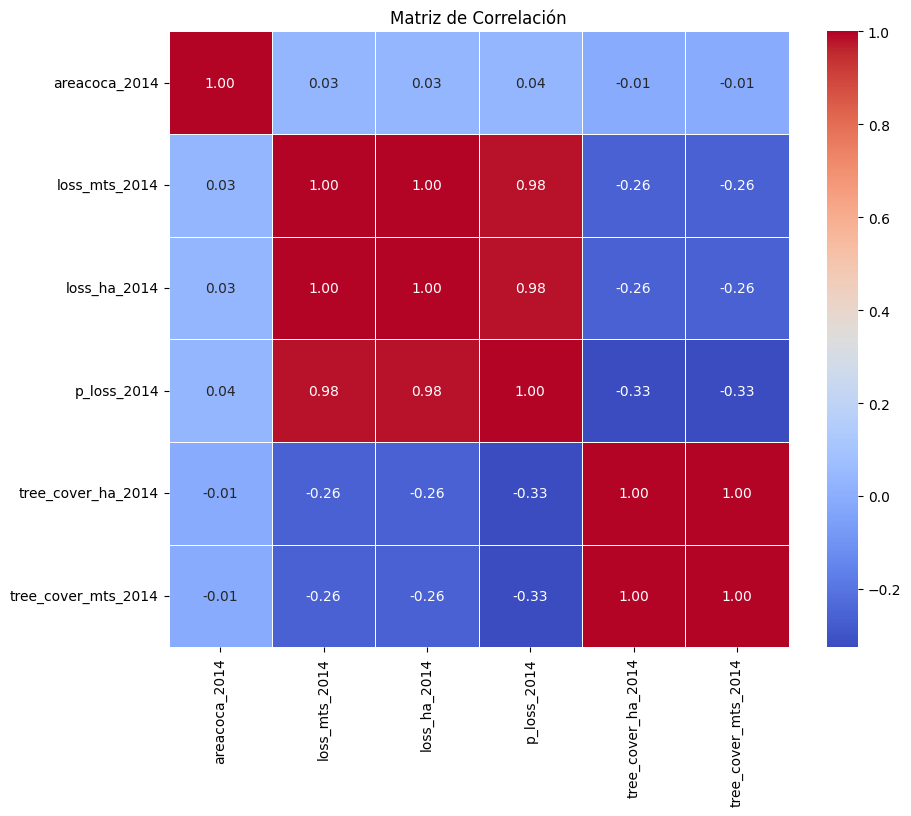

In [ ]:
# Crear un DataFrame con las columnas seleccionadas
data_selected = data_no_nulls[selected_columns]

# Calcular la matriz de correlación
correlation_matrix = data_selected.corr()

# Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

##Visualización de distribución de datos espacialmente

In [ ]:
# Cargar el archivo GeoJSON
file_path_no_nulls = '/content/drive/MyDrive/2.TRABAJOS/CESED/dataputumayo_no_nulls.geojson'
data_no_nulls = gpd.read_file(file_path_no_nulls)


In [ ]:
# plot GIS data on different basemaps by geopandas and contextily
!pip install geopandas
!pip install contextily
import geopandas as gpd
import contextily as ctx # for basemaps

In [ ]:
data = gpd.read_file("/content/drive/MyDrive/2.TRABAJOS/CESED/Putumayo.shp")

In [ ]:
# Reproyectar data_no_nulls al sistema de coordenadas de data
data_no_nulls = data_no_nulls.to_crs(data.crs)


In [ ]:
# Verificar el sistema de coordenadas actual de data
print("CRS de data:", data.crs)

# Verificar el sistema de coordenadas actual de data_no_nulls
print("CRS de data_no_nulls:", data_no_nulls.crs)


CRS de data: PROJCS["CTM12",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
CRS de data_no_nulls: PROJCS["CTM12",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",20

In [ ]:
# Reproyectar data al sistema de coordenadas de data_no_nulls
data = data.to_crs(data_no_nulls.crs)

In [ ]:
from matplotlib.colors import ListedColormap

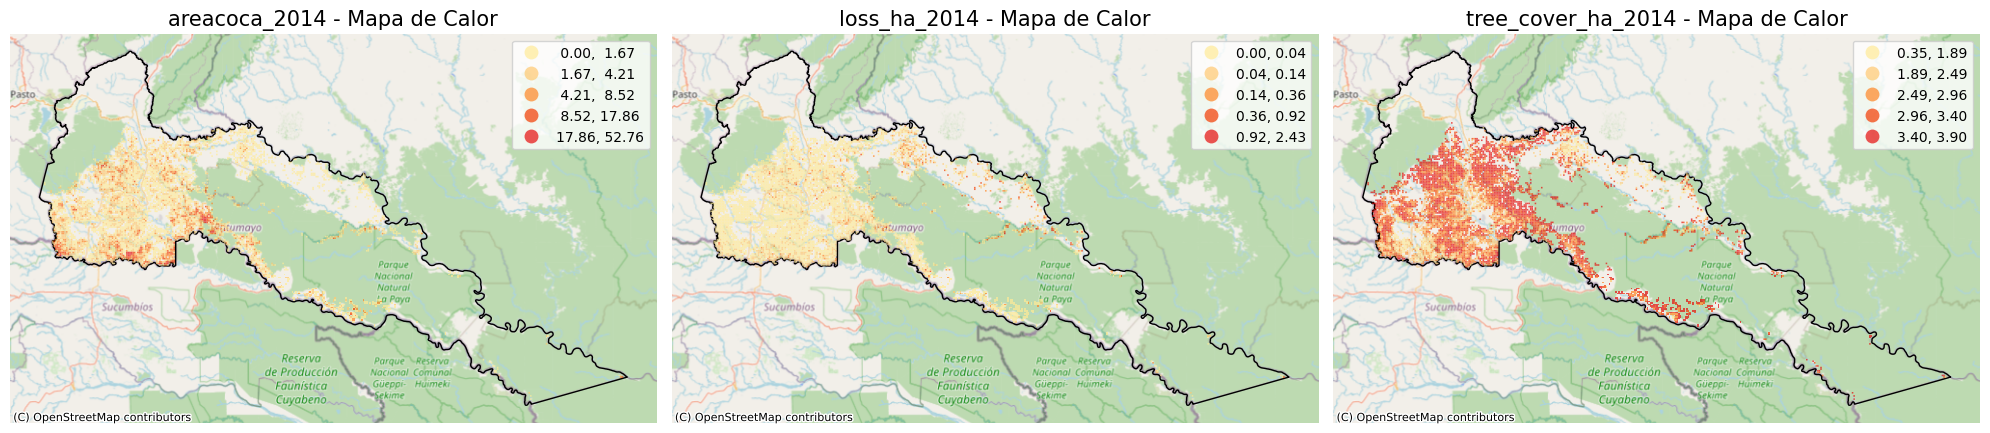

In [ ]:
# Seleccionar las columnas para la visualización
selected_columns = ['areacoca_2014', 'loss_ha_2014', 'tree_cover_ha_2014']

# Colores personalizados para cada columna
colors_areacoca = ['#FFEB97', '#FFC970', '#FF8523', '#F33A00', '#E60D0C']
colors_loss = ['#FFEB97', '#FFC970', '#FF8523', '#F33A00', '#E60D0C']
colors_tree_cover = ['#FFEB97', '#FFC970', '#FF8523', '#F33A00', '#E60D0C']

# Crear colormaps personalizados
cmap_areacoca = ListedColormap(colors_areacoca)
cmap_loss = ListedColormap(colors_loss)
cmap_tree_cover = ListedColormap(colors_tree_cover)

# Configuraciones adicionales
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, selected_column in enumerate(selected_columns):
    # Visualización con esquema de cuantiles para el shapefile
    ax = axs[i]

    # Visualización del shapefile
    data.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)  # Configuración del borde negro y relleno transparente

    # Añadir basemap
    ctx.add_basemap(ax, crs=data.crs, source=ctx.providers.OpenStreetMap.Mapnik)

    # Visualización de datos adicionales con el colormap personalizado
    data_no_nulls.plot(column=selected_column, cmap=cmap_areacoca, linewidth=0, ax=ax, edgecolor='0.8', legend=True, scheme='natural_breaks', alpha=0.7, zorder=1)

    # Configuraciones adicionales
    ax.set_title(f"{selected_column} - Mapa de Calor", fontdict={'fontsize': '15', 'fontweight': '3'})
    ax.axis('off')

# Ajustes de diseño
plt.tight_layout()

# Mostrar los mapas
plt.show()

## Resultados del AED
El análisis exploratorio de datos y la distribución espacial a simple vista no muestra patrones que correlacionen la deforestación con los cultivos de coca, es por esto que se procede a hacer análisis geoestadistico mediante detección de hot spot utilizando los métodos de "Getis Ord gi*"  y  "Local Moran's I" los cuales permiten detectar autocorrelación entre áreas vecinas usando métodos de adyacencia y proximidad.


## CÁLCULO DE GETIS ORD GI*

In [ ]:
# Lista de columnas de interés
columnas_interes = ['areacoca_2014', 'loss_mts_2014', 'loss_ha_2014', 'p_loss_2014', 'tree_cover_ha_2014', 'tree_cover_mts_2014']

# Crear un nuevo DataFrame para almacenar los resultados de Getis-Ord GI*
resultados_gi = pd.DataFrame(index=data_no_nulls.index)

# Construir matriz de pesos espaciales (queen contigüidad)
w = weights.Queen.from_dataframe(data_no_nulls)

# Calcular el Getis-Ord GI* para cada columna
for columna in columnas_interes:
    gi = esda.G_Local(data_no_nulls[columna], w, star=True, permutations=99)
    resultados_gi[columna + '_gi'] = gi.z_sim

# Concatenar los resultados de GI* con el DataFrame original
data_gi = pd.concat([data_no_nulls, resultados_gi], axis=1)

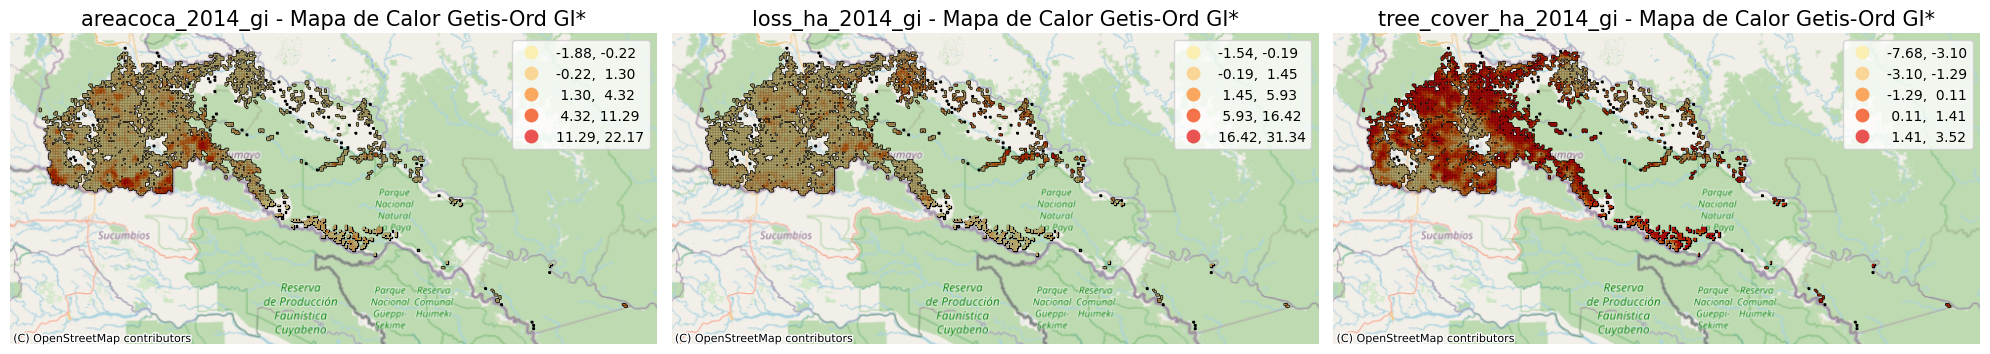

In [ ]:
# Reproyectar data al sistema de coordenadas de data_no_nulls
data_gi = data_gi.to_crs(data_no_nulls.crs)

# Seleccionar las columnas para la visualización
selected_columns_gi = ['areacoca_2014_gi', 'loss_ha_2014_gi', 'tree_cover_ha_2014_gi']

# Colores personalizados para cada columna
colors_gi = ['#FFEB97', '#FFC970', '#FF8523', '#F33A00', '#E60D0C']

# Crear colormap personalizado
cmap_gi = ListedColormap(colors_gi)

# Configuraciones adicionales
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, selected_column_gi in enumerate(selected_columns_gi):
    # Visualización con esquema de cuantiles para el shapefile
    ax = axs[i]

    # Visualización del shapefile
    data_gi.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)  # Configuración del borde negro y relleno transparente

    # Añadir basemap
    ctx.add_basemap(ax, crs=data_gi.crs, source=ctx.providers.OpenStreetMap.Mapnik)

    # Visualización de datos adicionales con el colormap personalizado
    data_gi.plot(column=selected_column_gi, cmap=cmap_gi, linewidth=0, ax=ax, edgecolor='0.8', legend=True, scheme='natural_breaks', alpha=0.7, zorder=1)

    # Configuraciones adicionales
    ax.set_title(f"{selected_column_gi} - Mapa de Calor Getis-Ord GI*", fontdict={'fontsize': '15', 'fontweight': '3'})
    ax.axis('off')

# Ajustes de diseño
plt.tight_layout()

# Mostrar los mapas
plt.show()

## LOCAL MORAN´S L

In [ ]:
# Ruta del nuevo archivo GeoJSON sin valores nulos
nuevo_file_path = '/content/drive/MyDrive/2.TRABAJOS/CESED/dataputumayo_no_nulls.geojson'

# Cargar el nuevo GeoJSON en un GeoDataFrame
gdf_nuevo = gpd.read_file(nuevo_file_path)

# Visualizar los primeros registros del GeoDataFrame
print(gdf_nuevo.head())

   grilla  areacoca_2014  loss_mts_2014  loss_ha_2014  p_loss_2014  \
0  107971         0.9375       0.000000      0.000000     0.000000   
1  109050         0.5625       0.000000      0.000000     0.000000   
2  110139         1.6875     720.000000      0.072000     1.850596   
3  115611         7.8187     237.678466      0.023768     0.610347   
4  115612        11.4508    4393.327017      0.439333    11.864836   

   tree_cover_ha_2014  tree_cover_mts_2014  \
0            3.497632         34976.323569   
1            3.893667         38936.669036   
2            3.567778         35677.776212   
3            3.235989         32359.889616   
4            2.152652         21526.517905   

                                            geometry  
0  POLYGON ((-74.39529 -0.52854, -74.39529 -0.519...  
1  POLYGON ((-74.39529 -0.51045, -74.39529 -0.501...  
2  POLYGON ((-74.40427 -0.49236, -74.40427 -0.483...  
3  POLYGON ((-73.88325 -0.40193, -73.88325 -0.392...  
4  POLYGON ((-73.87427 -0.4

In [ ]:
# Crear la matriz de pesos espaciales con la reina
w_reina_nuevo = weights.Queen.from_dataframe(gdf_nuevo)

# Crear un nuevo DataFrame para almacenar los resultados de Moran Local
resultados_moran_nuevo = gdf_nuevo[['geometry']].copy()

# Calcular Moran Local para cada columna de interés
columnas_interes = ['areacoca_2014', 'loss_ha_2014', 'p_loss_2014', 'tree_cover_ha_2014']
for columna in columnas_interes:
    moran_local_nuevo = esda.Moran_Local(gdf_nuevo[columna], w_reina_nuevo)
    resultados_moran_nuevo[columna + '_quadrant'] = moran_local_nuevo.q


<Figure size 600x600 with 0 Axes>

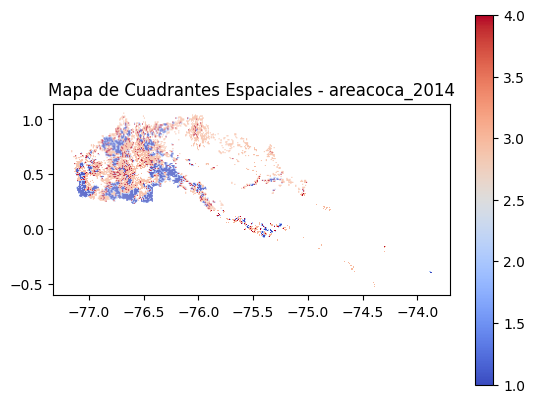

<Figure size 600x600 with 0 Axes>

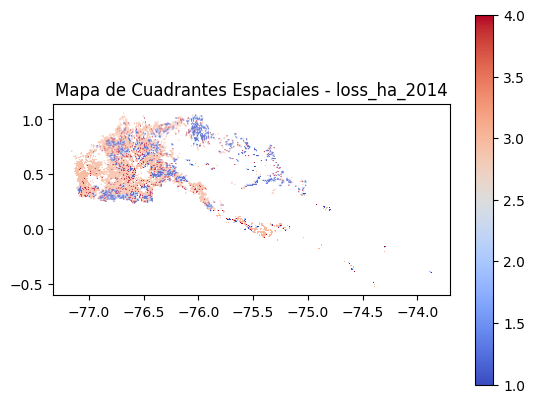

<Figure size 600x600 with 0 Axes>

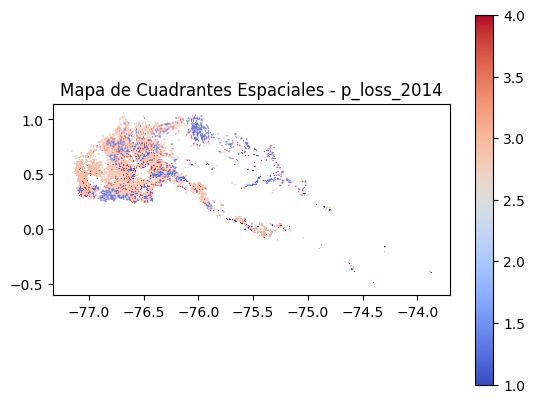

<Figure size 600x600 with 0 Axes>

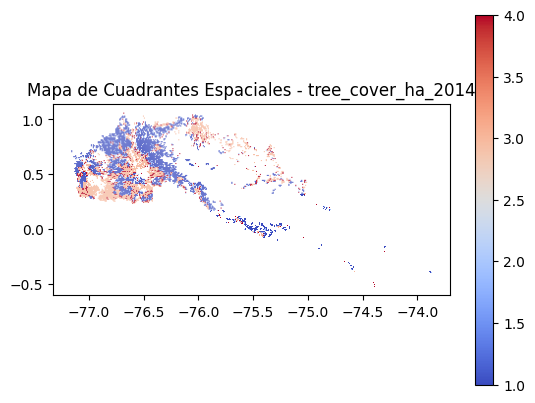

<ipython-input-12-e7ca91184513>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=resultados_moran_nuevo, x=columna + '_quadrant', palette='coolwarm')


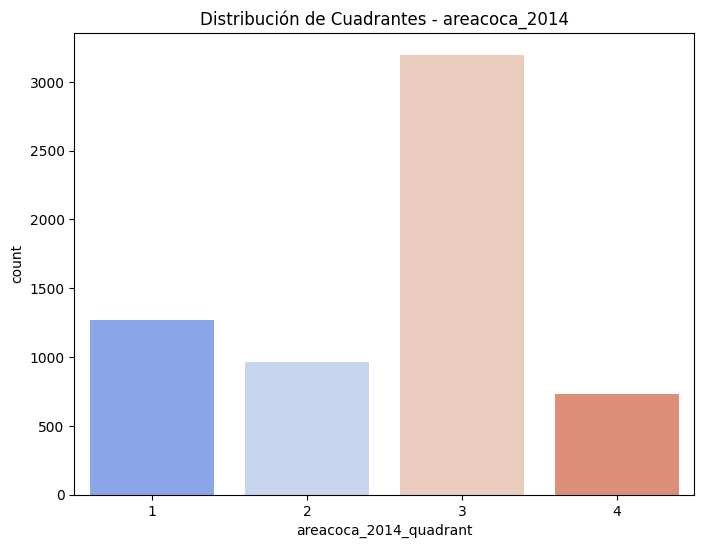

<ipython-input-12-e7ca91184513>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=resultados_moran_nuevo, x=columna + '_quadrant', palette='coolwarm')


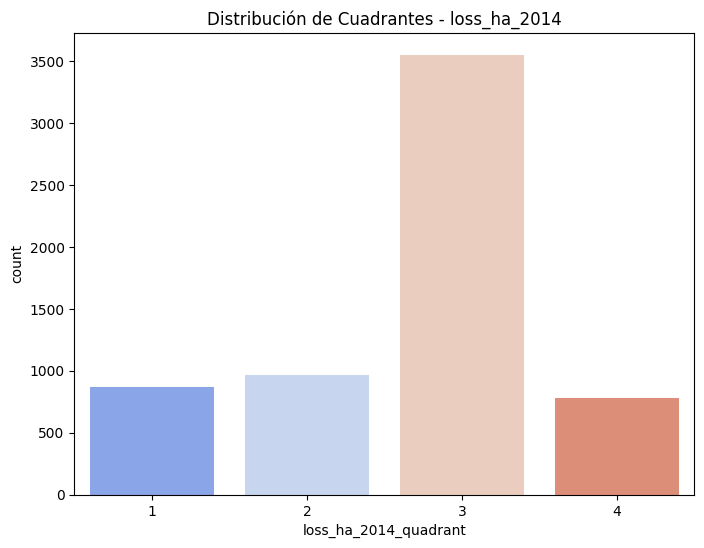

<ipython-input-12-e7ca91184513>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=resultados_moran_nuevo, x=columna + '_quadrant', palette='coolwarm')


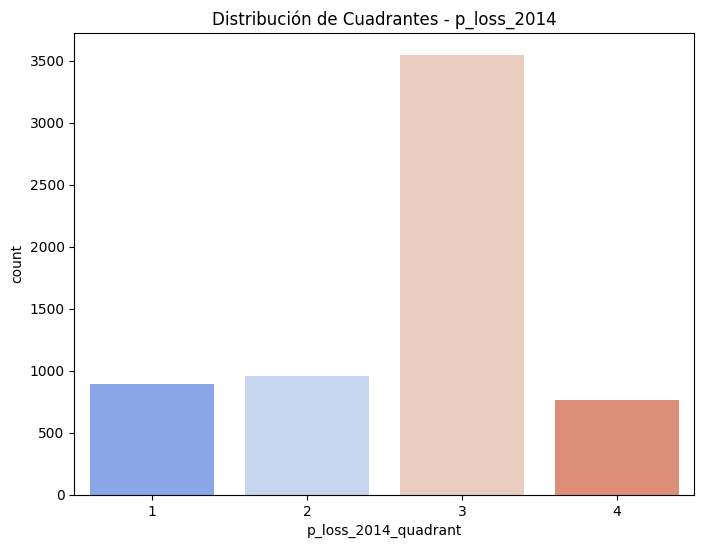

<ipython-input-12-e7ca91184513>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=resultados_moran_nuevo, x=columna + '_quadrant', palette='coolwarm')


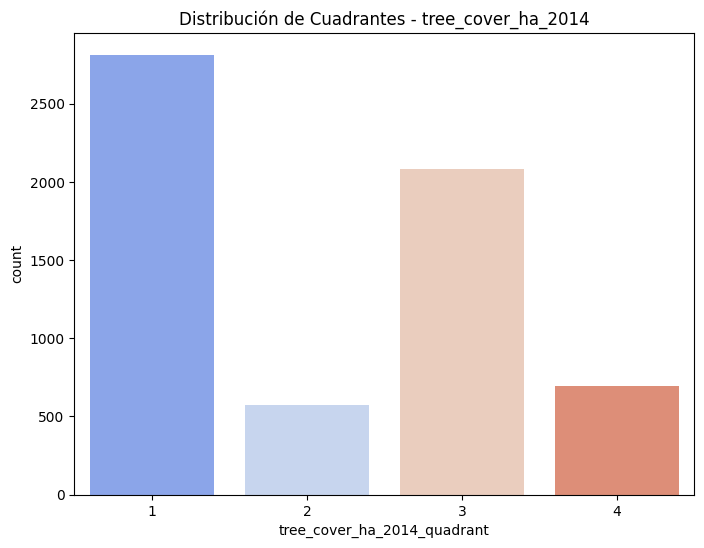

In [ ]:
# Mapear los cuadrantes espaciales con el nuevo DataFrame
for columna in columnas_interes:
    plt.figure(figsize=(6, 6))
    resultados_moran_nuevo.plot(column=columna + '_quadrant', cmap='coolwarm', legend=True)
    plt.title(f'Mapa de Cuadrantes Espaciales - {columna}')
    plt.show()

# Visualizar la frecuencia de los cuadrantes con el nuevo DataFrame
for columna in columnas_interes:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=resultados_moran_nuevo, x=columna + '_quadrant', palette='coolwarm')
    plt.title(f'Distribución de Cuadrantes - {columna}')
    plt.show()

In [ ]:
# Añadir las columnas de cuadrantes al nuevo GeoDataFrame
gdf_nuevo['areacoca_2014_quadrant'] = resultados_moran_nuevo['areacoca_2014_quadrant']
gdf_nuevo['loss_ha_2014_quadrant'] = resultados_moran_nuevo['loss_ha_2014_quadrant']
gdf_nuevo['p_loss_2014_quadrant'] = resultados_moran_nuevo['p_loss_2014_quadrant']
gdf_nuevo['tree_cover_ha_2014_quadrant'] = resultados_moran_nuevo['tree_cover_ha_2014_quadrant']

# Guardar el nuevo GeoDataFrame con las columnas de cuadrantes en un nuevo GeoJSON
nuevo_file_path_cuadrantes = '/content/drive/MyDrive/2.TRABAJOS/CESED/cuadrantes2.geojson'
gdf_nuevo.to_file(nuevo_file_path_cuadrantes, driver='GeoJSON')

# Imprimir la ruta del nuevo archivo GeoJSON con las columnas de cuadrantes
print(f"Nuevo archivo GeoJSON con las columnas de cuadrantes guardado en: {nuevo_file_path_cuadrantes}")


Nuevo archivo GeoJSON con las columnas de cuadrantes guardado en: /content/drive/MyDrive/2.TRABAJOS/CESED/cuadrantes2.geojson


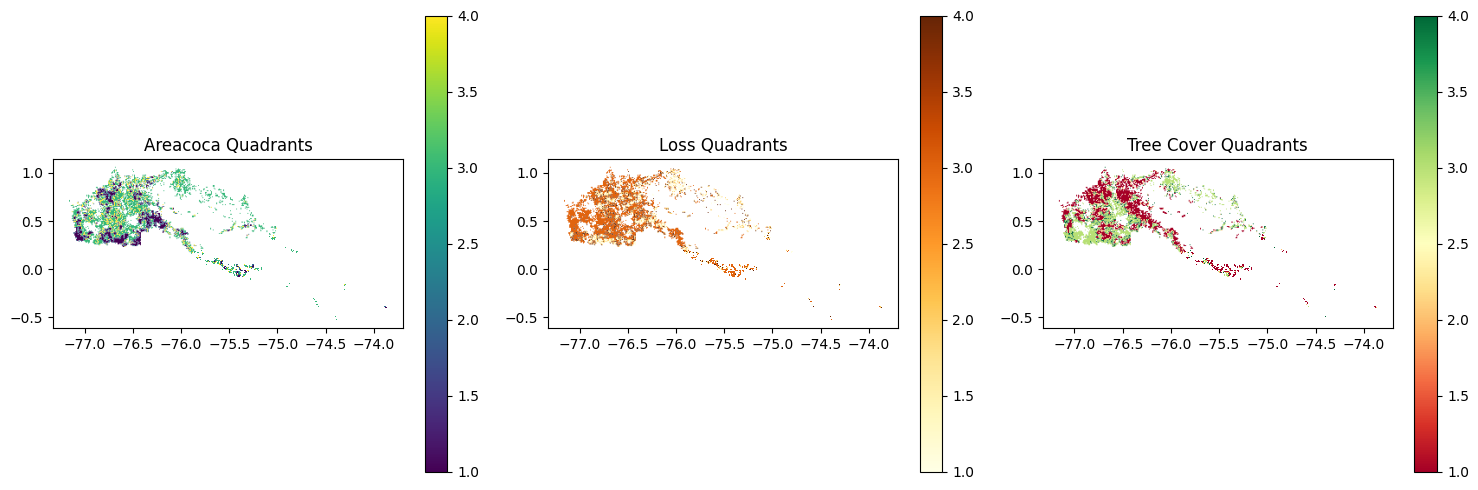

In [ ]:
# Cargar el nuevo GeoJSON con las columnas de cuadrantes
gdf_cuadrantes = gpd.read_file(nuevo_file_path_cuadrantes)

# Crear tres GeoDataFrames separados por cuadrante
gdf_areacoca = gdf_cuadrantes[['geometry', 'areacoca_2014_quadrant']]
gdf_loss = gdf_cuadrantes[['geometry', 'loss_ha_2014_quadrant']]
gdf_tree_cover = gdf_cuadrantes[['geometry', 'tree_cover_ha_2014_quadrant']]

# Guardar cada GeoDataFrame en un archivo GeoJSON separado
gdf_areacoca = gdf_areacoca.dissolve(by='areacoca_2014_quadrant', as_index=False)
gdf_areacoca.to_file('areacoca_quadrants.geojson', driver='GeoJSON')

gdf_loss = gdf_loss.dissolve(by='loss_ha_2014_quadrant', as_index=False)
gdf_loss.to_file('loss_quadrants.geojson', driver='GeoJSON')

gdf_tree_cover = gdf_tree_cover.dissolve(by='tree_cover_ha_2014_quadrant', as_index=False)
gdf_tree_cover.to_file('tree_cover_quadrants.geojson', driver='GeoJSON')

# Visualizar los resultados
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar los archivos GeoJSON
gdf_areacoca = gpd.read_file('areacoca_quadrants.geojson')
gdf_loss = gpd.read_file('loss_quadrants.geojson')
gdf_tree_cover = gpd.read_file('tree_cover_quadrants.geojson')

# Crear un mapa con los colores especificados
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Mapear Areacoca
gdf_areacoca.plot(ax=axes[0], column='areacoca_2014_quadrant', cmap='viridis', legend=True)
axes[0].set_title('Areacoca Quadrants')

# Mapear Loss
gdf_loss.plot(ax=axes[1], column='loss_ha_2014_quadrant', cmap='YlOrBr', legend=True)
axes[1].set_title('Loss Quadrants')

# Mapear Tree Cover
gdf_tree_cover.plot(ax=axes[2], column='tree_cover_ha_2014_quadrant', cmap='RdYlGn', legend=True)
axes[2].set_title('Tree Cover Quadrants')

plt.tight_layout()
plt.show()

In [ ]:
# Guardar cada GeoDataFrame en un archivo GeoJSON separado en la carpeta CESED
gdf_areacoca = gdf_areacoca.dissolve(by='areacoca_2014_quadrant', as_index=False)
gdf_areacoca.to_file('/content/drive/MyDrive/2.TRABAJOS/CESED/areacoca_quadrants.geojson', driver='GeoJSON')

gdf_loss = gdf_loss.dissolve(by='loss_ha_2014_quadrant', as_index=False)
gdf_loss.to_file('/content/drive/MyDrive/2.TRABAJOS/CESED/loss_quadrants.geojson', driver='GeoJSON')



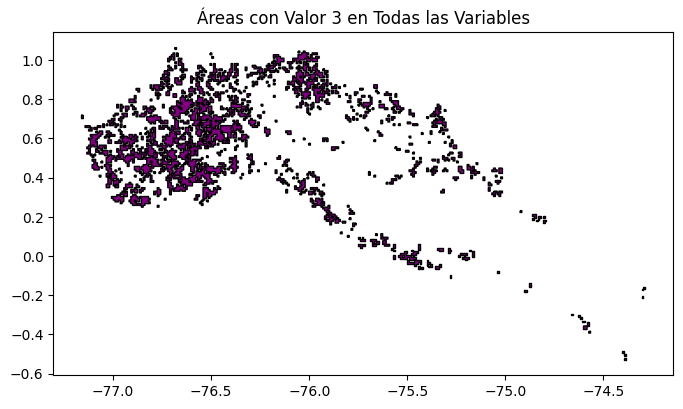

In [ ]:
# Seleccionar áreas con valores de 3 en todas las variables
areas_con_valor_3 = gdf_areacoca[gdf_areacoca['areacoca_2014_quadrant'] == 3].index.intersection(
                       gdf_loss[gdf_loss['loss_ha_2014_quadrant'] == 3].index).intersection(
                       gdf_tree_cover[gdf_tree_cover['tree_cover_ha_2014_quadrant'] == 3].index)
# Crear un nuevo GeoDataFrame con las áreas seleccionadas
gdf_areas_valor_3 = gdf_areacoca.loc[areas_con_valor_3].copy()
# Crear un mapa con las áreas seleccionadas
fig, ax = plt.subplots(figsize=(8, 8))
gdf_areas_valor_3.plot(ax=ax, color='purple', edgecolor='black')
ax.set_title('Áreas con Valor 3 en Todas las Variables')
plt.show()

In [ ]:
# Ruta para guardar las áreas con valor 3 como GeoJSON
ruta_guardado_areas_valor_3 = '/content/drive/MyDrive/2.TRABAJOS/CESED/areas_valor_3.geojson'
# Guardar las áreas con valor 3 como GeoJSON
gdf_areas_valor_3.to_file(ruta_guardado_areas_valor_3, driver='GeoJSON')
# Mostrar la ruta del archivo GeoJSON guardado
print(f"Áreas con Valor 3 guardadas en: {ruta_guardado_areas_valor_3}")


Áreas con Valor 3 guardadas en: /content/drive/MyDrive/2.TRABAJOS/CESED/areas_valor_3.geojson


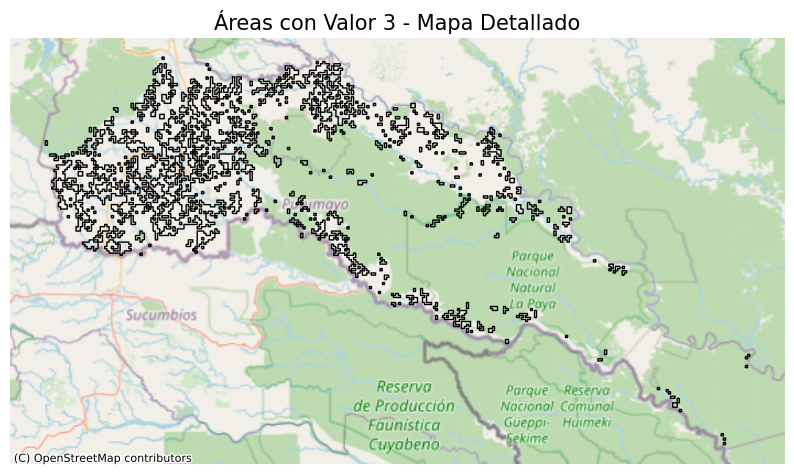

In [ ]:
# Reproyectar gdf_areas_valor_3 al sistema de coordenadas de data_no_nulls
gdf_areas_valor_3 = gdf_areas_valor_3.to_crs(data_no_nulls.crs)

# Configuraciones adicionales
fig, ax = plt.subplots(figsize=(10, 10))

# Visualización del shapefile de áreas con valor 3
gdf_areas_valor_3.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Añadir basemap
ctx.add_basemap(ax, crs=gdf_areas_valor_3.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Configuraciones adicionales
ax.set_title('Áreas con Valor 3 - Mapa Detallado', fontdict={'fontsize': '15', 'fontweight': '3'})
ax.axis('off')

# Mostrar el mapa
plt.show()

Número de parches: 567

# ANÁLISIS FOCALIZADO

In [ ]:
# Cargar los GeoJSON con las columnas de cuadrantes
gdf_areacoca = gpd.read_file('/content/drive/MyDrive/2.TRABAJOS/CESED/areacoca_quadrants.geojson')
gdf_loss = gpd.read_file('/content/drive/MyDrive/2.TRABAJOS/CESED/loss_quadrants.geojson')

# Reproyectar gdf_areacoca y gdf_loss al sistema de coordenadas de data
gdf_areacoca = gdf_areacoca.to_crs(data.crs)
gdf_loss = gdf_loss.to_crs(data.crs)

# Verificar las proyecciones después de la reproyección
print("Proyección después de reproyección de gdf_areacoca:", gdf_areacoca.crs)
print("Proyección después de reproyección de gdf_loss:", gdf_loss.crs)


Proyección después de reproyección de gdf_areacoca: PROJCS["CTM12",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Proyección después de reproyección de gdf_loss: PROJCS["CTM12",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992]

/usr/local/lib/python3.10/dist-packages/mapclassify/classifiers.py:686: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self._classify()
/usr/local/lib/python3.10/dist-packages/mapclassify/classifiers.py:686: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self._classify()


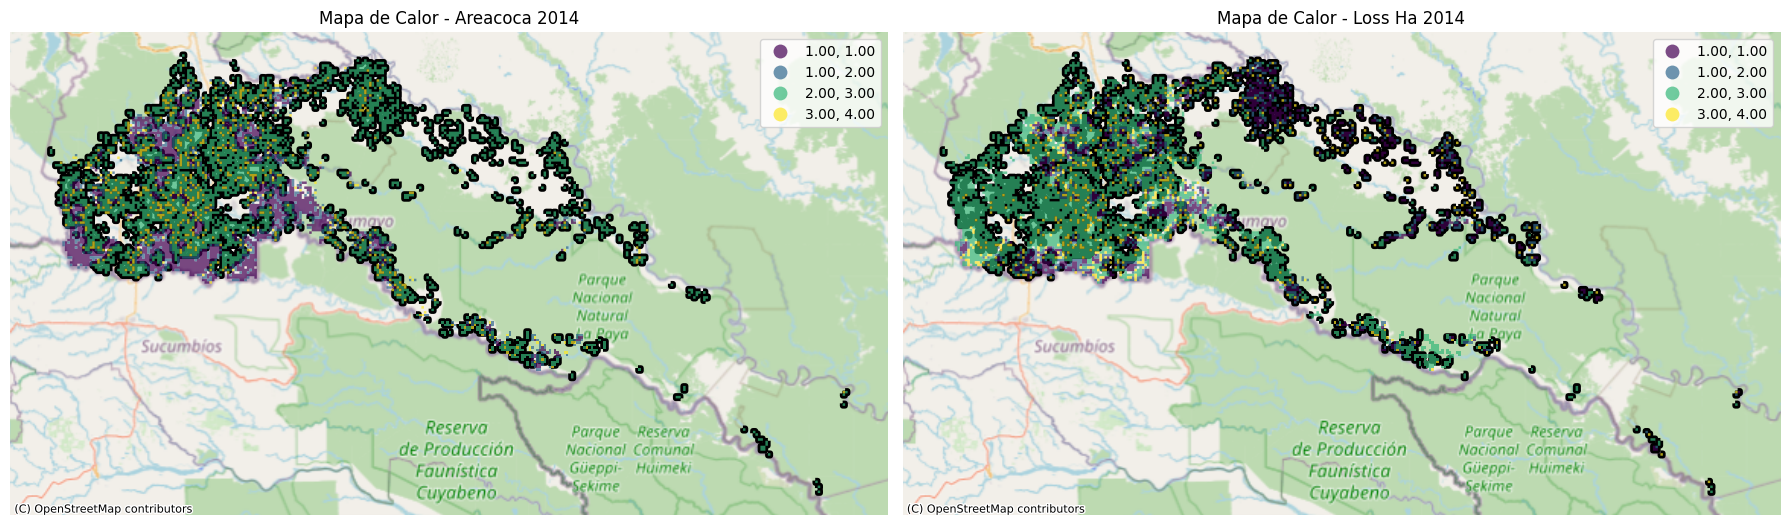

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx  # Asegúrate de tener esta librería instalada

# Configuraciones adicionales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))  # Crear dos subplots

# Visualización del shapefile
gdf_areas_valor_3.plot(ax=ax1, edgecolor='black', facecolor='none', linewidth=4)  # Borde del área
ctx.add_basemap(ax1, crs=gdf_areas_valor_3.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Mapa de calor para 'areacoca_2014'
gdf_areacoca.plot(column='areacoca_2014_quadrant', cmap='viridis', linewidth=0, ax=ax1, edgecolor='none', legend=True, scheme='natural_breaks', alpha=0.7, zorder=1)

# Configuraciones adicionales
ax1.set_title('Mapa de Calor - Areacoca 2014')
ax1.axis('off')

# Visualización del shapefile
gdf_areas_valor_3.plot(ax=ax2, edgecolor='black', facecolor='none', linewidth=4)  # Borde del área
ctx.add_basemap(ax2, crs=gdf_areas_valor_3.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Mapa de calor para 'loss_ha_2014'
gdf_loss.plot(column='loss_ha_2014_quadrant', cmap='viridis', linewidth=0, ax=ax2, edgecolor='none', legend=True, scheme='natural_breaks', alpha=0.7, zorder=1)

# Configuraciones adicionales
ax2.set_title('Mapa de Calor - Loss Ha 2014')
ax2.axis('off')

# Ajustes de diseño
plt.tight_layout()

# Mostrar el mapa
plt.show()

## Resultados del análisis geoestadistico

La relación espacial entre las áreas de mayor densidad de cultivos de coca y las zonas de pérdida de superficie es coherente.

Sin embargo, estas áreas de cultivo densamente establecidas son un punto focal crucial. Por lo tanto, más allá de la lógica y los cambios previos en el territorio, es esencial examinar las dinámicas de sucesión ecológica y antropogénica que seguirán los patrones de cobertura. Como se evidencia en la figura siguiente, se ha otorgado especial atención a la autocorrelación entre áreas adyacentes mediante métodos de adyacencia y proximidad. Estos métodos permiten visualizar parches de áreas de cultivo de coca con alta densidad, rodeados ya sea de áreas de baja densidad o viceversa. Estas configuraciones son consideradas como posibles indicadores de aumentos de densidad y se han denominado como "clusters".Es importante destacar que estos "clusters" muestran una correlación significativa con las zonas que experimentan una mayor tasa de deforestación, subrayando así la interrelación entre los patrones de cultivo de coca y la pérdida de cobertura forestal.


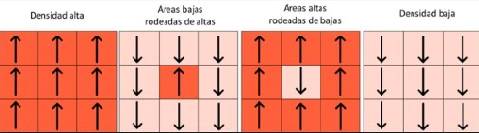


In [ ]:
import geopandas as gpd

# Cargar el GeoDataFrame con áreas contiguas
coca1 = gpd.read_file('/content/drive/MyDrive/2.TRABAJOS/CESED/areacoca_quadrants.geojson')

# Convertir geometrías multipart a singlepart
coca2 = coca1.explode()

# Guardar el GeoDataFrame resultante como archivo GeoJSON
coca2.to_file("/content/drive/MyDrive/2.TRABAJOS/CESED/output/areacoca_quadrants.geojson", driver="GeoJSON")


<ipython-input-32-9124f49e45de>:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  coca2 = coca1.explode()


In [ ]:
# Cargar el GeoDataFrame con áreas contiguas
loss1 = gpd.read_file('/content/drive/MyDrive/2.TRABAJOS/CESED/loss_quadrants.geojson')

# Convertir geometrías multipart a singlepart
loss2 = loss1.explode()

# Guardar el GeoDataFrame resultante como archivo GeoJSON
loss2.to_file("/content/drive/MyDrive/2.TRABAJOS/CESED/output/loss_quadrants.geojson", driver="GeoJSON")


<ipython-input-35-d49072af8cda>:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  loss2 = loss1.explode()


In [ ]:
# Cargar el GeoDataFrame con áreas contiguas
tree1 = gpd.read_file('/content/drive/MyDrive/2.TRABAJOS/CESED/tree_cover_quadrants.geojson')

# Convertir geometrías multipart a singlepart
tree2 = tree1.explode()

# Guardar el GeoDataFrame resultante como archivo GeoJSON
tree2.to_file("/content/drive/MyDrive/2.TRABAJOS/CESED/output/tree_quadrants.geojson", driver="GeoJSON")


<ipython-input-36-31064e7ad5e7>:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  tree2 = tree1.explode()
